In [1]:
import os, math
import numpy as np
import pandas as pd
from scipy import signal

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv("../input/ion-clean/train_full_clean.csv")
test = pd.read_csv("../input/ion-clean/test_full_clean.csv")
sub = pd.read_csv("../input/liverpool-ion-switching/sample_submission.csv")

train["group"] = np.arange(train.shape[0]) // 500_000
test["group"] = np.arange(test.shape[0]) // 100_000

In [3]:
# reduce df occupied memory

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        if col!='open_channels':
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
# create signal processing features

def calc_gradients(s, n_grads=4):
    '''
    Calculate gradients for a pandas series. Returns the same number of samples
    '''
    grads = pd.DataFrame()
    
    g = s.values
    for i in range(n_grads):
        g = np.gradient(g)
        grads['grad_' + str(i+1)] = g
        
    return grads

def calc_low_pass(s, n_filts=5):
    '''
    Applies low pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.3, n_filts)
    
    low_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='low')
        zi = signal.lfilter_zi(b, a)
        low_pass['lowpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        low_pass['lowpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return low_pass

def calc_high_pass(s, n_filts=5):
    '''
    Applies high pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.1, n_filts)
    
    high_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='high')
        zi = signal.lfilter_zi(b, a)
        high_pass['highpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        high_pass['highpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return high_pass

def calc_ewm(s, windows=[10, 100]):
    '''
    Calculates exponential weighted functions
    '''
    ewm = pd.DataFrame()
    for w in windows:
        ewm['ewm_mean_' + str(w)] = s.ewm(span=w, min_periods=1).mean()
        ewm['ewm_std_' + str(w)] = s.ewm(span=w, min_periods=1).std()
        
    # add zeros when na values (std)
    ewm = ewm.fillna(value=0)
        
    return ewm

def calc_signal_features(s):
    '''
    All calculations together
    '''
    low_pass = calc_low_pass(s)
    high_pass = calc_high_pass(s)
    ewm = calc_ewm(s)
    
    return pd.concat([s, low_pass, high_pass, ewm], axis=1)

def signal_features(s, signal_size=500000):
    '''
    Divide the signal in bags of "signal_size".
    Normalize the data dividing it by 15.0
    '''
    # normalize
    s = s / 15.0
    
    ls = []
    for i in range(s.shape[0]//signal_size):
        sig = s[i*signal_size:(i+1)*signal_size].copy().reset_index(drop=True)
        sig_featured = calc_signal_features(sig)
        ls.append(sig_featured)
    
    ls = pd.concat(ls, axis=0)
    return ls[ls.columns[1:]]

In [5]:
# rolling and aggreagate batch features
def rolling_features(df):
    for window in [10, 100]:
        # rolling
        df['mean_t' + str(window)] = df.groupby(['group'])['signal'].transform(lambda x: x.rolling(window).mean())
        df['std_t' + str(window)] = df.groupby(['group'])['signal'].transform(lambda x: x.rolling(window).std())
        df['var_t' + str(window)] = df.groupby(['group'])['signal'].transform(lambda x: x.rolling(window).var())
        df['q25_t' + str(window)] = df.groupby(['group'])['signal'].transform(lambda x: x.rolling(window).quantile(0.25))
        df['q50_t' + str(window)] = df.groupby(['group'])['signal'].transform(lambda x: x.rolling(window).quantile(0.50))
        df['q75_t' + str(window)] = df.groupby(['group'])['signal'].transform(lambda x: x.rolling(window).quantile(0.75))
        df['min_t' + str(window)] = df.groupby(['group'])['signal'].transform(lambda x: x.rolling(window).min())
        df['max_t' + str(window)] = df.groupby(['group'])['signal'].transform(lambda x: x.rolling(window).max())
        min_max = (df['signal'] - df['min_t' + str(window)]) / (df['max_t' + str(window)] - df['min_t' + str(window)])
        df['norm_t' + str(window)] = min_max * (np.floor(df['max_t' + str(window)]) - np.ceil(df['min_t' + str(window)]))
    return df.fillna(0)

def shifted_features(df, num_shift=5):
    steps = np.arange(1, num_shift+1, dtype=np.int32)
    steps = np.append(steps, -steps)
    for step in steps:
        df['signal_shift_' + str(step)] = df['signal'].shift(step, fill_value=-2.73).astype( np.float32 )
    return df

def add_category(df):
    # treat 10 open channels group as another category
    df["category"] = 0
    if df.shape[0] > 2_000_000:
        # train segments with more then 9 open channels classes
        df.loc[2_000_000:2_500_000, 'category'] = 1
        df.loc[4_500_000:5_000_000, 'category'] = 1
    else:
        # test segments with more then 9 open channels classes (potentially)
        df.loc[500_000:600_000-1, "category"] = 1
        df.loc[700_000:800_000-1, "category"] = 1
    return df

def add_features(df):
    df = shifted_features(df)
    df = rolling_features(df)
    df = add_category(df)
    df['signal_2'] = df['signal'] ** 2
    df = reduce_mem_usage(df).reset_index(drop=True)
    sg_df = signal_features(df['signal'])
    sg_df = reduce_mem_usage(sg_df).reset_index(drop=True)
    return pd.concat([df, sg_df], axis=1)

def augment_data(df):
    aug_df = df[df["group"] == 5].copy()
    aug_df["category"] = 1
    aug_df["group"] = 10
    for col in ["signal", "open_channels"]:
        aug_df[col] += df[df["group"] == 8][col].values

    aug_df['category'] = aug_df['category'].astype( np.int8 )
    df = df.append(aug_df, sort=False)
    return df

def drop_columns(df, columns=('open_channels', 'time', 'group')):
    return df[[c for c in df.columns if c not in columns]]

In [6]:
%%time

train = add_features(train)
test = drop_columns(add_features(test))
train = augment_data(train)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_inds = list(kf.split(train, train["group"]))
trn_ind, val_ind = cv_inds[0]
trn_ind = shuffle(trn_ind)

trn, val = train.iloc[trn_ind], train.iloc[val_ind]

Mem. usage decreased to 343.32 Mb (69.0% reduction)
Mem. usage decreased to 267.03 Mb (72.0% reduction)
Mem. usage decreased to 122.07 Mb (71.4% reduction)
Mem. usage decreased to 106.81 Mb (72.0% reduction)
CPU times: user 52.2 s, sys: 16.4 s, total: 1min 8s
Wall time: 1min 8s


In [7]:
model = RandomForestClassifier(
            n_estimators=50,
            max_depth=18,
            max_features=11,        
            random_state=42,
            n_jobs=10,
            verbose=1,
            bootstrap=False, #Don't use repeated rows, this is important to set to False to improve accuracy
        ).fit( drop_columns(trn), trn.open_channels )  # drop_columns(trn)[:50000], trn.open_channels[:50000]

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 25.4min
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed: 41.7min finished


In [8]:
pred_val = model.predict( drop_columns(val) )

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    4.9s finished


In [9]:
f1_score(val.open_channels, pred_val, average="macro")

0.9438314881972866

In [10]:
pred_test = model.predict( test )

sub.open_channels = np.round( pred_test ).astype(np.int32)
sub.to_csv("submission.csv", index=False, float_format='%.4f')

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    7.0s finished


In [11]:
def plot_feature_importance(features, importances):
    plt.figure(figsize=(12, 14))
    sns.barplot(x = importances, y = features)
    plt.xlabel('Importance', fontsize=13)
    plt.ylabel('Feature', fontsize=13)
    plt.tick_params(axis='x', labelsize=11)
    plt.tick_params(axis='y', labelsize=11)
    plt.title('Light Gradient Boosting Feature Importance (5 KFold)')
    plt.show()

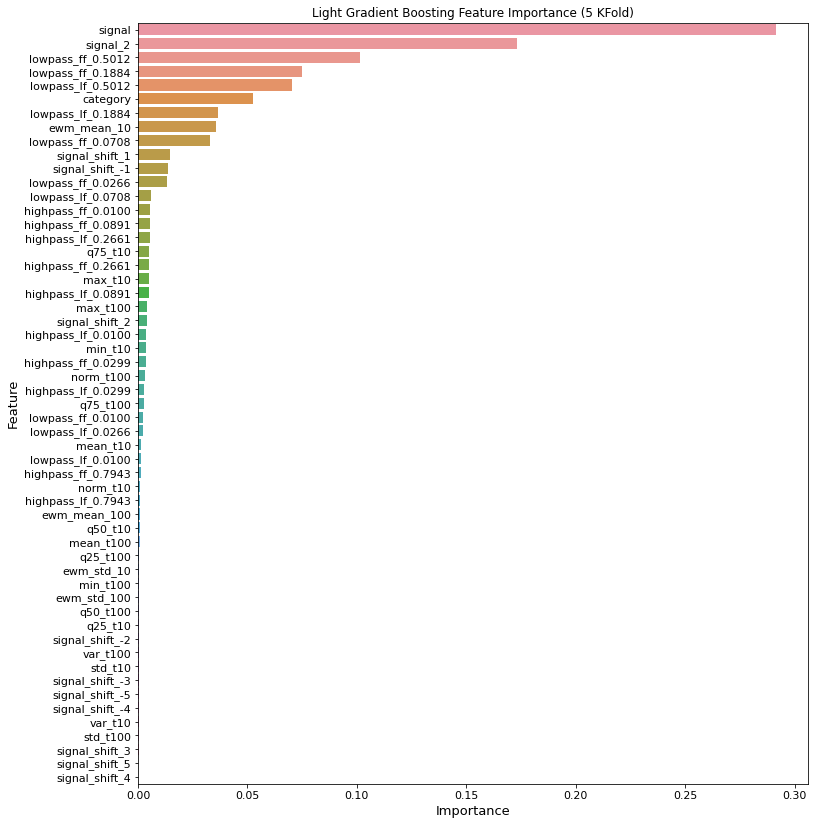

In [12]:
ind = np.argsort(model.feature_importances_)[::-1]
plot_feature_importance(drop_columns(trn).columns[ind], model.feature_importances_[ind])